In [8]:
# Cell 1: Install libraries, check GPU, load dataset

!pip install transformers datasets --quiet
!pip install torch --quiet

import torch
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# ------------------------------
# GPU Check
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on device:", device)

# ------------------------------
# Load your dataset
# ------------------------------
df = pd.read_csv("dataset.csv")  # must have columns: phrase, sentiment

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Dataset preview:")
print(df.head())

# ------------------------------
# Encode labels
# ------------------------------
le = LabelEncoder()
df["label"] = le.fit_transform(df["sentiment"])

print("\nLabel mapping:")
for label, encoded in zip(le.classes_, le.transform(le.classes_)):
    print(f"{label} -> {encoded}")

# ------------------------------
# Train-test split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    df["phrase"], df["label"],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

print(f"\nTraining samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")


Running on device: cuda
Dataset preview:
                                              phrase sentiment
0  "Working as a team, where individuals come tog...       Hot
1  "The unbearable heat in the afternoon ruined a...      Dead
2     "Friendship is the journey of shared stories."       Hot
3  "The unrelenting rain on my day off feels like...      Dead
4  "The store is a cherished family-owned establi...      Cold

Label mapping:
Cold -> 0
Dead -> 1
Hot -> 2

Training samples: 2783
Testing samples: 696


In [9]:
# Cell 2: Tokenize text for BERT and prepare DataLoaders

from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# ------------------------------------------
# 1 — Load BERT tokenizer
# ------------------------------------------

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 64   # You can set 64 or 128 depending on text length

print("Tokenizing...")

# ------------------------------------------
# 2 — Tokenize training sentences
# ------------------------------------------

train_encodings = tokenizer(
    X_train.tolist(),
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

test_encodings = tokenizer(
    X_test.tolist(),
    padding=True,
    truncation=True,
    max_length=MAX_LEN,
    return_tensors="pt"
)

# Extract input_ids and attention masks
X_train_ids = train_encodings["input_ids"]
X_train_mask = train_encodings["attention_mask"]

X_test_ids = test_encodings["input_ids"]
X_test_mask = test_encodings["attention_mask"]

# Labels → tensors
y_train_tensor = torch.tensor(y_train.tolist())
y_test_tensor = torch.tensor(y_test.tolist())

# ------------------------------------------
# 3 — Build Datasets
# ------------------------------------------

train_dataset = TensorDataset(X_train_ids, X_train_mask, y_train_tensor)
test_dataset = TensorDataset(X_test_ids, X_test_mask, y_test_tensor)

# ------------------------------------------
# 4 — DataLoaders
# ------------------------------------------

BATCH_SIZE = 16   # Good for Colab GPU

train_loader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=BATCH_SIZE
)

test_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
    batch_size=BATCH_SIZE
)

print("Tokenization complete.")
print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))


Tokenizing...
Tokenization complete.
Train batches: 174
Test batches: 44


In [11]:
import torch
from tqdm import tqdm

epochs = 10

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")

    # --------------------
    # TRAIN
    # --------------------
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch in tqdm(train_loader):   # <-- FIXED NAME
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        optimizer.zero_grad()

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct_train += (preds == b_labels).sum().item()
        total_train += b_labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)  # <-- FIXED
    train_accuracy = correct_train / total_train
    train_losses.append(avg_train_loss)

    # --------------------
    # VALIDATION
    # --------------------
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for batch in tqdm(test_loader):   # <-- FIXED
            b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                labels=b_labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct_val += (preds == b_labels).sum().item()
            total_val += b_labels.size(0)

    avg_val_loss = total_val_loss / len(test_loader)  # <-- FIXED
    val_accuracy = correct_val / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

print("\nTraining Finished!")



===== Epoch 1/10 =====


100%|██████████| 44/44 [00:02<00:00, 18.35it/s]


Train Loss: 0.0015, Train Acc: 0.9996 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 2/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.38it/s]


Train Loss: 0.0011, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 3/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.25it/s]


Train Loss: 0.0012, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 4/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.02it/s]


Train Loss: 0.0012, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 5/10 =====


100%|██████████| 44/44 [00:02<00:00, 18.37it/s]


Train Loss: 0.0011, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 6/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.25it/s]


Train Loss: 0.0012, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 7/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.23it/s]


Train Loss: 0.0012, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 8/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.21it/s]


Train Loss: 0.0013, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 9/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.07it/s]


Train Loss: 0.0011, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

===== Epoch 10/10 =====


100%|██████████| 44/44 [00:02<00:00, 19.33it/s]

Train Loss: 0.0012, Train Acc: 1.0000 | Val Loss: 0.0842, Val Acc: 0.9856

Training Finished!


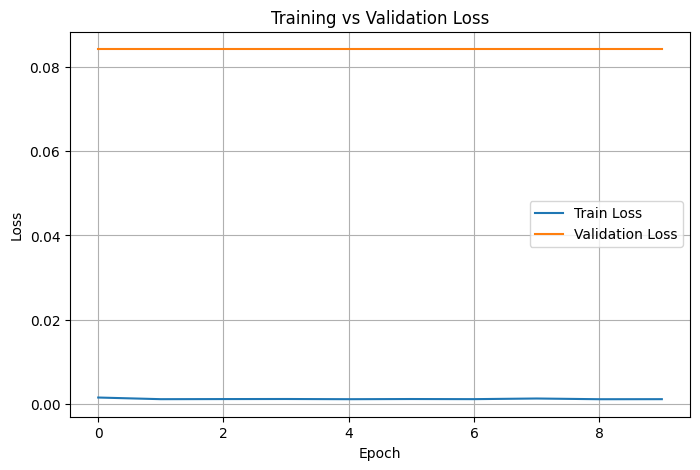

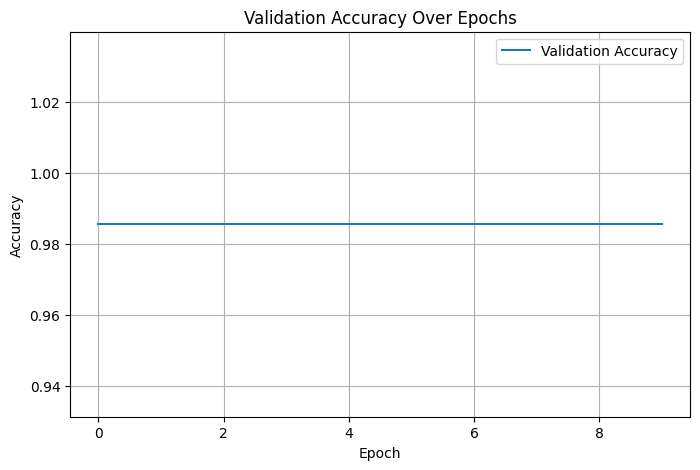

<Figure size 600x600 with 0 Axes>

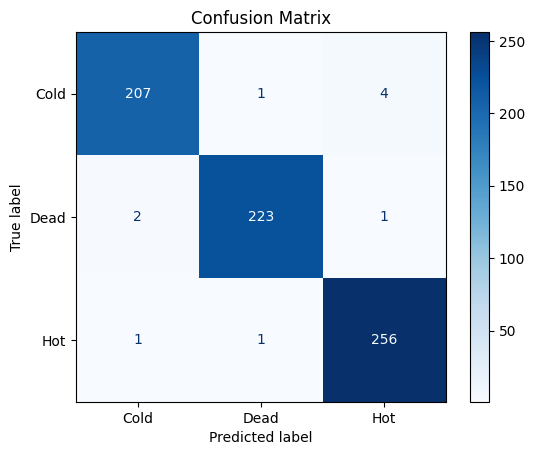


Classification Report:
              precision    recall  f1-score   support

        Cold       0.99      0.98      0.98       212
        Dead       0.99      0.99      0.99       226
         Hot       0.98      0.99      0.99       258

    accuracy                           0.99       696
   macro avg       0.99      0.99      0.99       696
weighted avg       0.99      0.99      0.99       696



In [14]:
# Cell: Evaluation graphs + metrics (updated for test_loader)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

label_names = ["Cold", "Dead", "Hot"]

# ===== 1. Training vs Validation Loss =====
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

# ===== 2. Validation Accuracy Curve =====
plt.figure(figsize=(8,5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()

# ===== 3. Generate Predictions =====
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:      # <-- FIXED
        b_input_ids, b_attention_mask, b_labels = [t.to(device) for t in batch]

        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask
        )

        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        predictions.extend(preds.cpu().numpy())
        true_labels.extend(b_labels.cpu().numpy())

# ===== 4. Confusion Matrix =====
cm = confusion_matrix(true_labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

plt.figure(figsize=(6,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

# ===== 5. Classification Report =====
print("\nClassification Report:")
print(classification_report(true_labels, predictions, target_names=label_names))
